In [1]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime

from src.utils.preprocess import generateFeatureSpace
from src.utils.model_runner import evaluate_models, evaluate_models_nested, plot_roc_curves, plot_precision_recall_curves, plot_classification_metric
from src.utils.data_handler import DataHandler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

DH = DataHandler()

Current working directory: /home/chris/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load Data</h1>

In [2]:
n_stage_grouped = {
    'NX': 0,
    'N0': 0,
    'N0 (I-)': 0,
    
    'N0 (I+)': 1,
    'N0 (MOL+)': 1,
    'N1MI': 1,
    
    'N1': 2,
    'N1A': 2,
    'N1B': 2,
    'N1C': 2,
    
    'N2': 3,
    'N2A': 3,
    
    'N3': 4,
    'N3A': 4,
    'N3B': 4,
    'N3C': 4
}

In [3]:
features = generateFeatureSpace()
features.set_index(['patient_id','sample_id'], inplace=True)
features.drop(columns=['Patient ID', 'Sample ID','PFI_over60mo'], inplace=True)

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
metadata['stage'] = metadata['Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code'].map(n_stage_grouped)
dfm = metadata['Disease Free (Months)']
dfs = metadata['Disease Free Status']
dfs = dfs.dropna()
dfm = dfm.dropna()
diseased = (dfm < 60) & (dfs == '1:Recurred/Progressed')

n_patients = features.index.nunique()
n_samples = features.shape[0]
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

generating initial feature space....
Number of rows with all NA in mutation columns (before): 352
Number of rows with all NA in mutation columns (after): 0
Adding latent dims to feature space...
data/raw/latent_space_5dim_BRCA_Normal.csv
data/raw/latent_space_5dim_BRCA_Her2.csv
data/raw/latent_space_5dim_BRCA_LumA.csv
data/raw/latent_space_5dim_BRCA_LumB.csv
data/raw/latent_space_5dim_BRCA_Basal.csv
There are 1073 patients and 1073 samples in the dataset.


In [4]:
df = features.copy()

def truncate_sample_id(s):
    parts = s.split('-')
    if len(parts) >= 4:
        return '-'.join(parts[:4])[:-1]
    else:
        return s

new_index = df.index.set_levels(
    df.index.levels[1].map(truncate_sample_id),
    level=1
)

df.index = new_index

In [5]:
df['stage'] = metadata['stage']

<h1>Generate X and y</h1>

In [6]:
X = df.copy()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(diseased.index)
print(f"Number of samples in intersection: {len(intersection_samples)}")

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
diseased = diseased.loc[intersection_samples]

X = X.reset_index().drop(columns=['sample_id']).set_index('patient_id')
diseased = diseased.reset_index().drop(columns=['Sample ID']).set_index('Patient ID')

# get bool of whether pfs is greater than 5 years
y = list(diseased[0])

Number of samples in intersection: 842


In [7]:
mutations = pd.read_csv('data/raw/TCGA.BRCA.mutations.txt', sep="\t")

non_synonymous_mutations = mutations[~mutations["Variant_Classification"].isin(["Silent", "Intron", "3'Flank", "3'UTR", "5'UTR"]) & (mutations["FILTER"] == "PASS")]
# ACTN4 + HIST1H3B + ITPR2 + MSH5
filter_genes = ["BRCA1","BRCA2","ACTN4", "HIST1H3B", "ITPR2", "MSH5"]
# coutn the number of non-synonymous mutations in the filter genes for each sample
mutation_count = non_synonymous_mutations[non_synonymous_mutations["Hugo_Symbol"].isin(filter_genes)].groupby(['patient_id','Hugo_Symbol']).size().unstack(fill_value=0)
mutation_count['BRCA'] = mutation_count['BRCA1'] + mutation_count['BRCA2'] > 0

In [8]:
X = pd.merge(X, mutation_count, left_index=True, right_index=True, how='left')
X = X.fillna(0)
X.shape

(842, 27)

In [9]:
#  Age +  Subtype + BRCA + Ethnicity_white + Stage   + latent_0_10 + latent_1_10  + latent_2_10 + latent_3_10 +latent_4_10  + ACTN4 + HIST1H3B + ITPR2 + MSH5

In [10]:
X.keys()

Index(['Diagnosis Age', 'Race Category', 'Tumor Type', 'Subtype', 'AKT1',
       'ARID1A', 'CDH1', 'ESR1', 'GATA3', 'KMT2C', 'MAP3K1', 'PIK3CA', 'PTEN',
       'TP53', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4',
       'stage', 'ACTN4', 'BRCA1', 'BRCA2', 'HIST1H3B', 'ITPR2', 'MSH5',
       'BRCA'],
      dtype='object')

In [11]:
keep_cols = ['Diagnosis Age', 'Subtype', 'BRCA', 'stage', 'Race Category', 'latent_1', 'latent_2', 'latent_3', 'latent_4',
       'ACTN4', 'HIST1H3B', 'ITPR2', 'MSH5']

X = X[keep_cols]

In [12]:
X

,Diagnosis Age,Subtype,BRCA,stage,Race Category,latent_1,latent_2,latent_3,latent_4,ACTN4,HIST1H3B,ITPR2,MSH5
patient_id,,,,,,,,,,,,,
TCGA-3C-AALI,5.0,BRCA_Her2,False,2.0,Non-white,-2.540501,-2.655398,-0.836810,-0.245725,0.0,1.0,0.0,0.0
TCGA-3C-AALJ,6.2,BRCA_LumB,0,2.0,Non-white,-2.687838,-2.297806,-1.246830,-0.162543,0.0,0.0,0.0,0.0
TCGA-4H-AAAK,5.0,BRCA_LumA,0,3.0,White,-0.741586,0.058618,0.012508,-0.023874,0.0,0.0,0.0,0.0
TCGA-A1-A0SB,7.0,BRCA_Normal,0,0.0,White,-5.131662,4.074389,0.966390,-6.787024,0.0,0.0,0.0,0.0
TCGA-A1-A0SD,5.9,BRCA_LumA,0,0.0,White,-0.084615,-0.217934,1.506106,0.636541,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB41,5.5,BRCA_LumA,0,1.0,Non-white,-4.356128,-0.680611,-5.605370,2.172641,0.0,0.0,0.0,0.0
TCGA-WT-AB44,7.7,BRCA_LumA,0,0.0,White,-5.302167,1.633947,-2.702706,0.538975,0.0,0.0,0.0,0.0
TCGA-XX-A899,4.6,BRCA_LumA,0,3.0,White,-2.200847,-1.533612,1.473531,1.229815,0.0,0.0,0.0,0.0


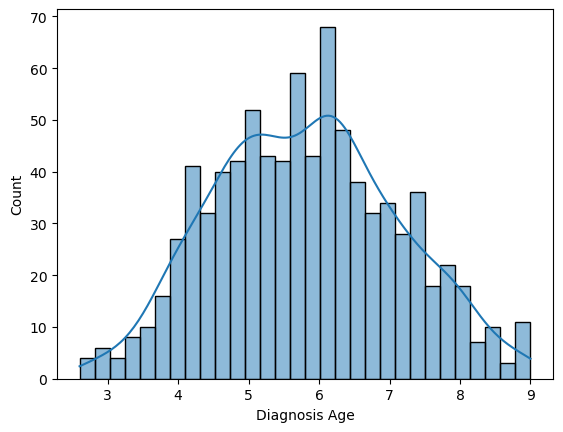

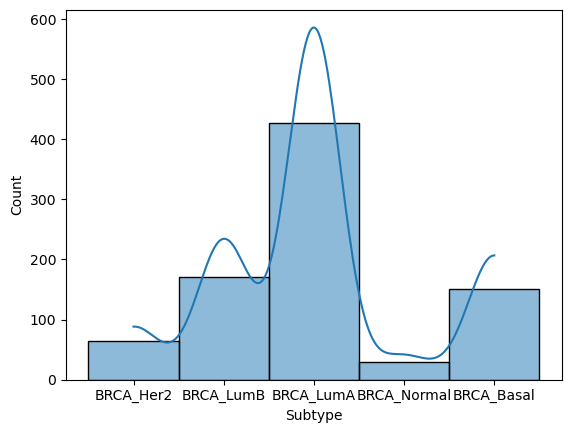

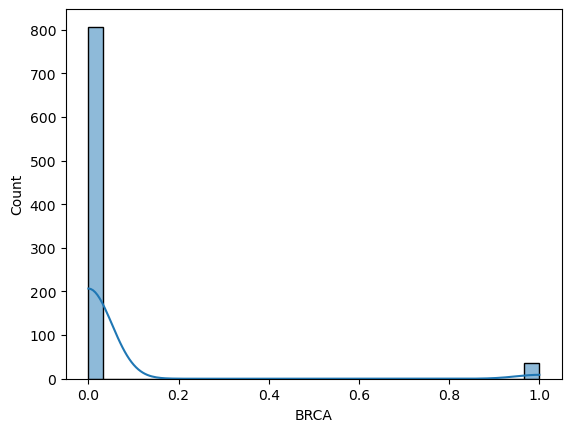

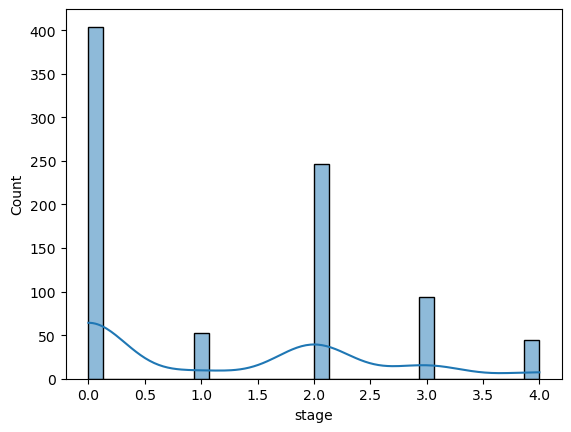

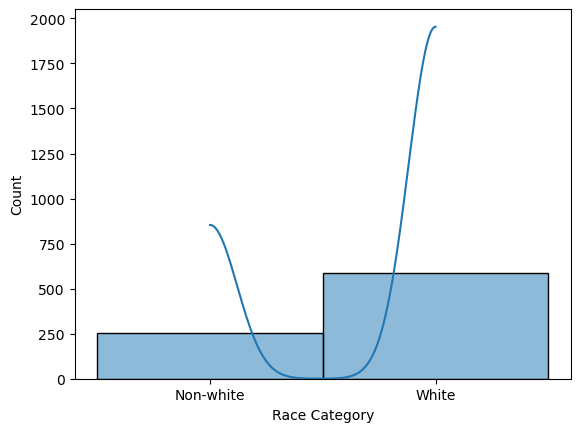

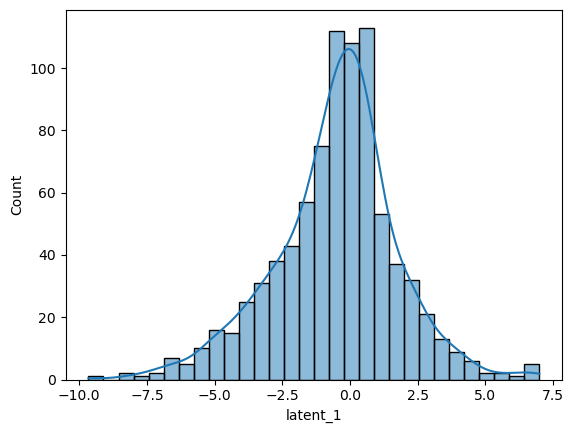

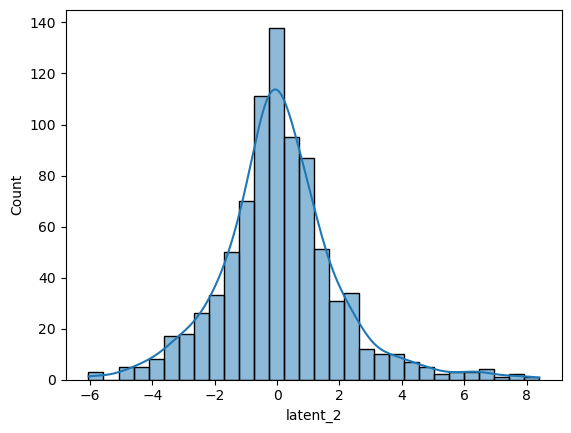

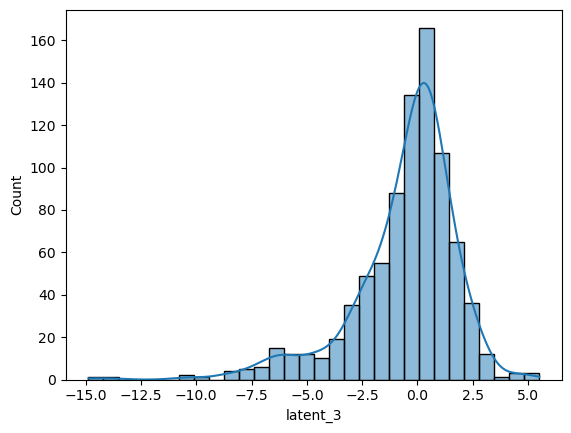

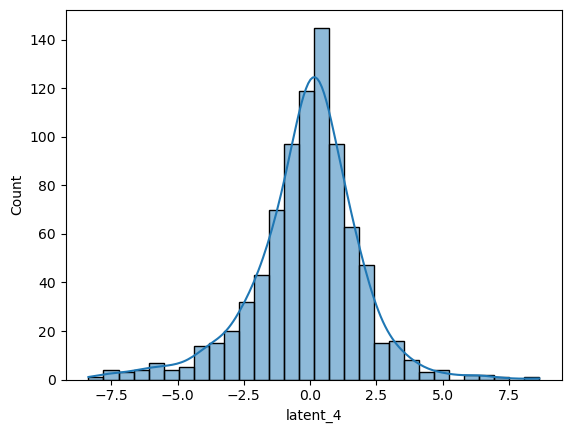

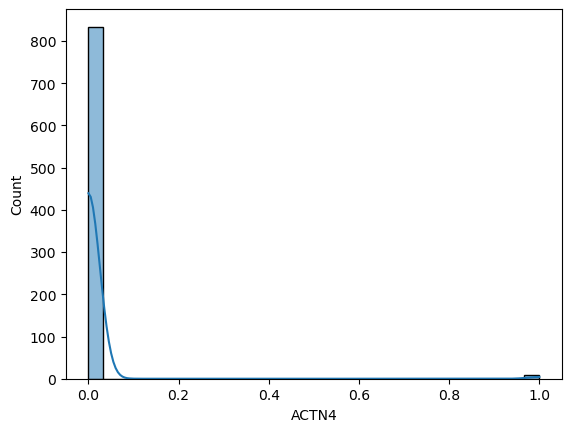

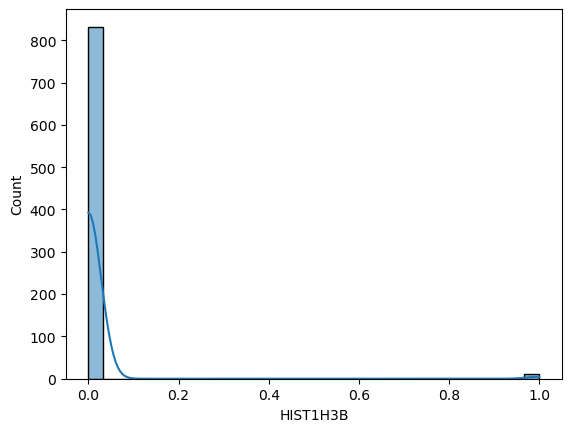

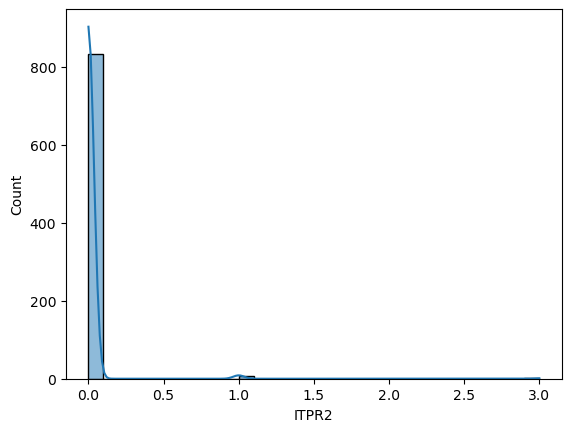

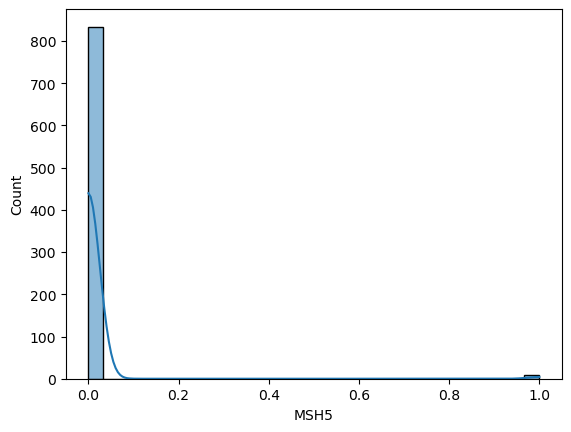

In [13]:
for col in X.columns:
    sns.histplot(X.loc[:,col], bins=30, kde=True)
    plt.show()

Text(0.5, 1.0, 'DFS > 5 years')

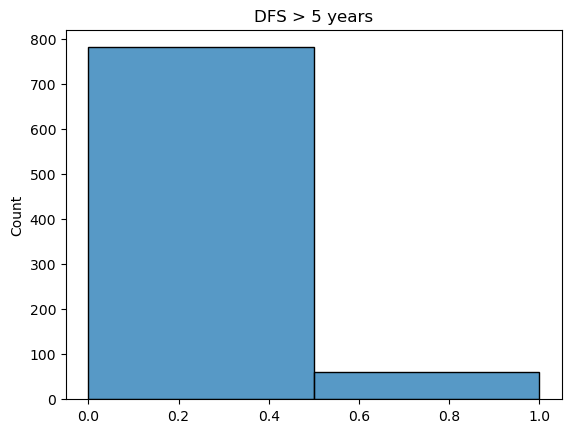

In [14]:
ax = sns.histplot(y, bins=2)
ax.set_title('DFS > 5 years')

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [15]:
categorical_cols = ['Subtype', 'BRCA', 'stage', 'Race Category']

def preprocessor(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    # One-hot encode categorical columns
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Optional: sort columns to ensure train/test consistency
    return X_encoded


def training_fold_filtering(X: pd.DataFrame, y: np.ndarray, k: int) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.

    Example filtering:
    1. Filter by mean expression
    2. Filter by variance
    3. Filter by within-class variance
    5. Select top k features using SelectKBest
    """
    X = X.copy()
    X = DH.filter_genes_by_within_class_variance(X, y)

    if len(X.columns) < k:
        print(f"Warning: Less than {k} features after mean and variance filtering. Found {len(X.columns)} features.")
        print(f"Using all {len(X.columns)} features.")
        k = len(X.columns)

    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_genes = X.columns[selector.get_support()].tolist()
    return pd.DataFrame(X_new, columns=selected_genes, index=X.index), selected_genes

In [16]:
# evaluate models with different number of features
results = {}
for k in range(1, 20):
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models(X, y, filter_data=training_fold_filtering, k=k, preprocess=preprocessor)

# find the top 4 models based on average of models' f1 score
f1_scores = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['F1 Score']['global'])
    f1_scores.append(np.mean(scores))
    result_k.append(k)

# get the top 3 models
top_k = np.asarray(result_k)[np.argsort(f1_scores)[-3:][::-1]]

Evaluating models with top 1 features...
Evaluating models with top 2 features...
Evaluating models with top 3 features...
Evaluating models with top 4 features...
Evaluating models with top 5 features...
Evaluating models with top 6 features...
Evaluating models with top 7 features...
Evaluating models with top 8 features...
Evaluating models with top 9 features...
Evaluating models with top 10 features...
Evaluating models with top 11 features...
Evaluating models with top 12 features...
Evaluating models with top 13 features...
Evaluating models with top 14 features...
Evaluating models with top 15 features...
Evaluating models with top 16 features...
Evaluating models with top 17 features...
Evaluating models with top 18 features...
Evaluating models with top 19 features...
Using all 18 features.
Using all 18 features.
Using all 18 features.
Using all 18 features.


<h1>plot data</h1>

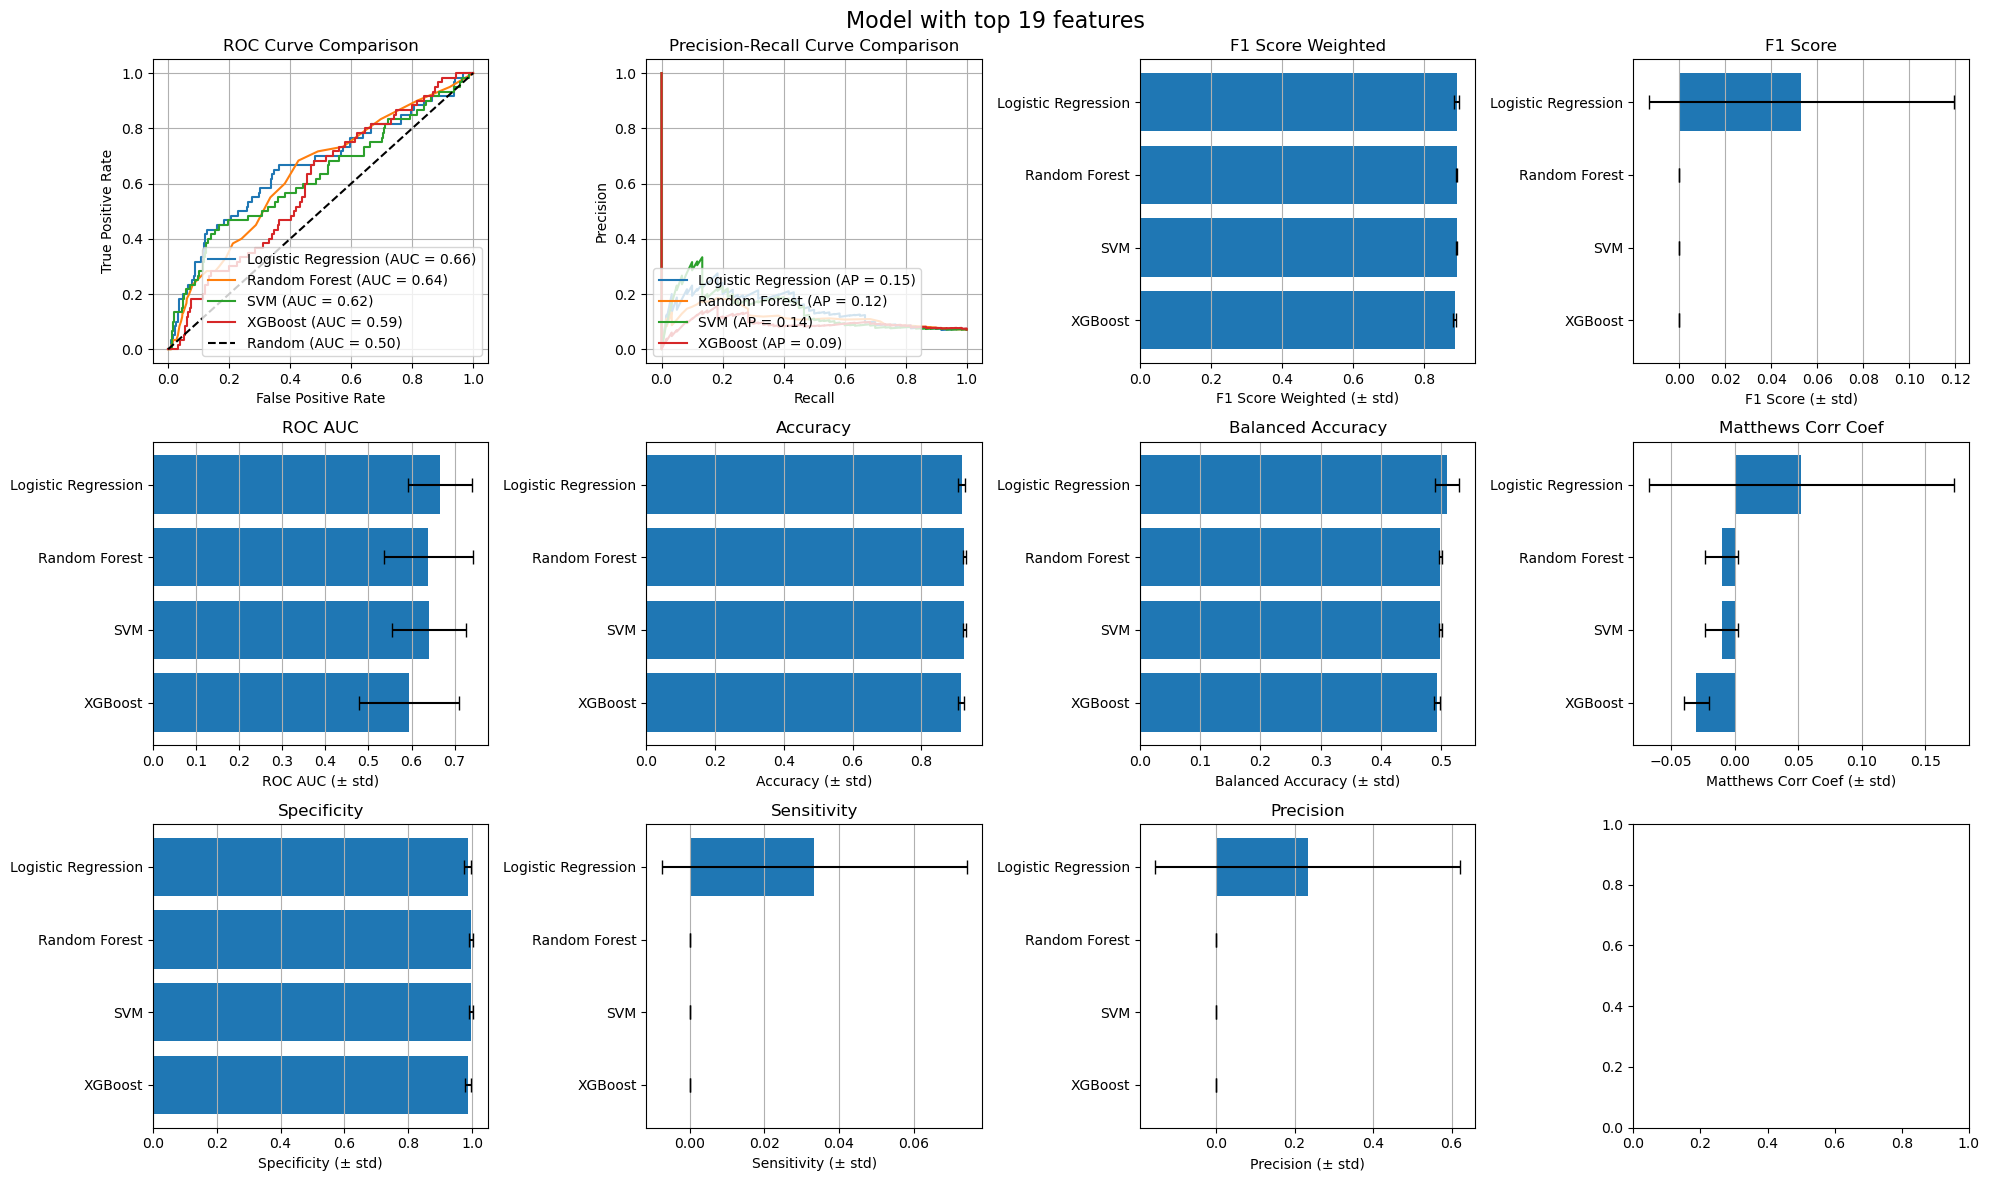

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

k = 19

plot_roc_curves(results[k], ax=axes[0, 0])
plot_precision_recall_curves(results[k], ax=axes[0, 1])
plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
plot_classification_metric(results[k], ax=axes[0, 3], metric='F1 Score')
plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
plot_classification_metric(results[k], ax=axes[1, 2], metric='Balanced Accuracy')
plot_classification_metric(results[k], ax=axes[1, 3], metric='Matthews Corr Coef')
plot_classification_metric(results[k], ax=axes[2, 0], metric='Specificity')
plot_classification_metric(results[k], ax=axes[2, 1], metric='Sensitivity')
plot_classification_metric(results[k], ax=axes[2, 2], metric='Precision')
fig.suptitle(f"Model with top {k} features", fontsize=16)
fig.tight_layout()

In [22]:
sets = [set(a) for a in results[11]['Logistic Regression']['features']]
print(f"intersected features: {set.intersection(*sets)}")

intersected features: {'stage_3.0', 'latent_3', 'ACTN4', 'MSH5', 'HIST1H3B', 'stage_4.0', 'Diagnosis Age'}


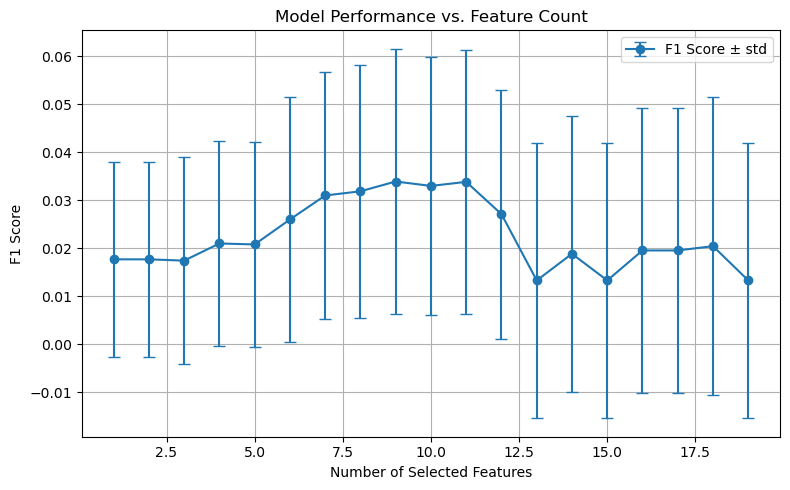

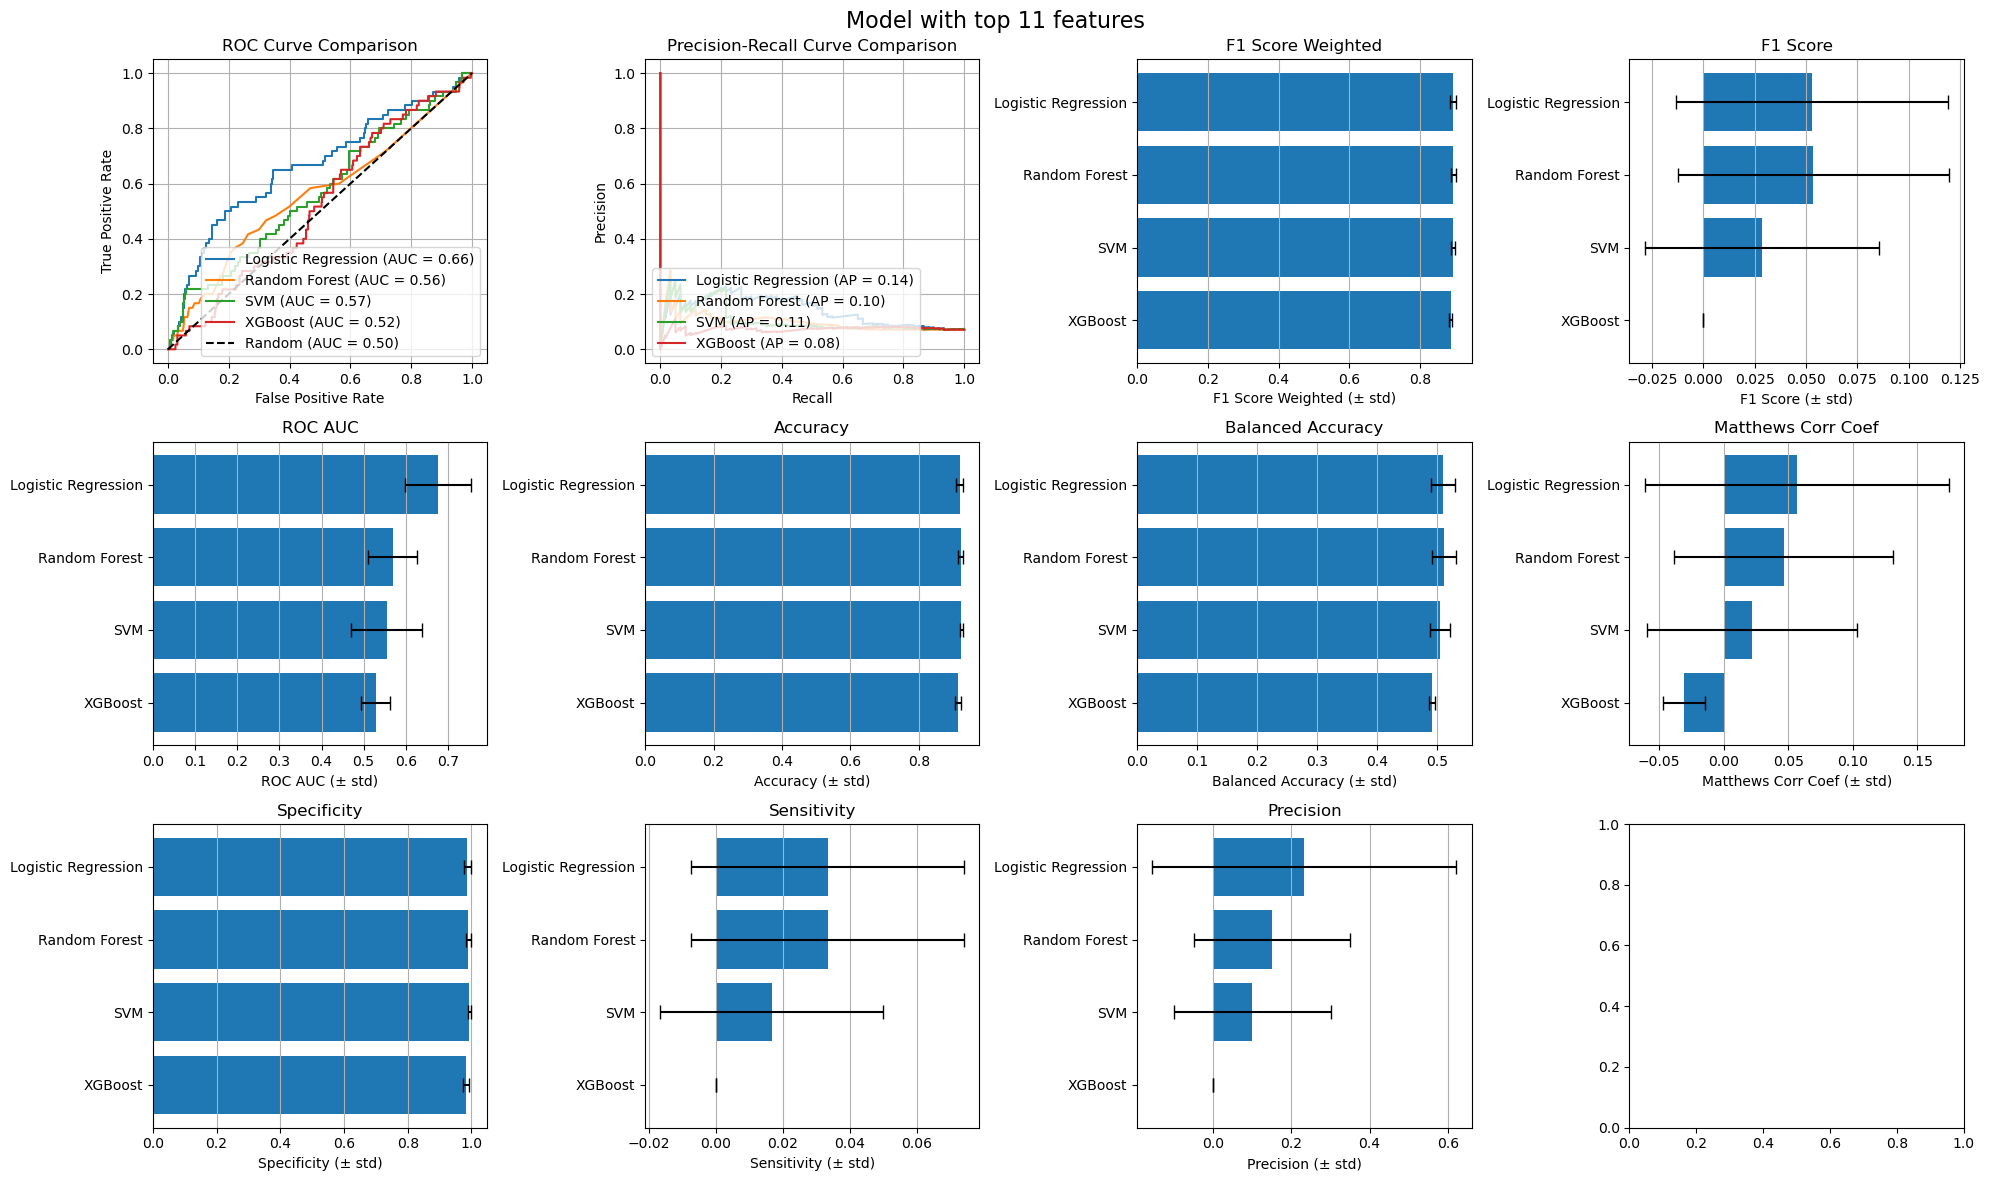

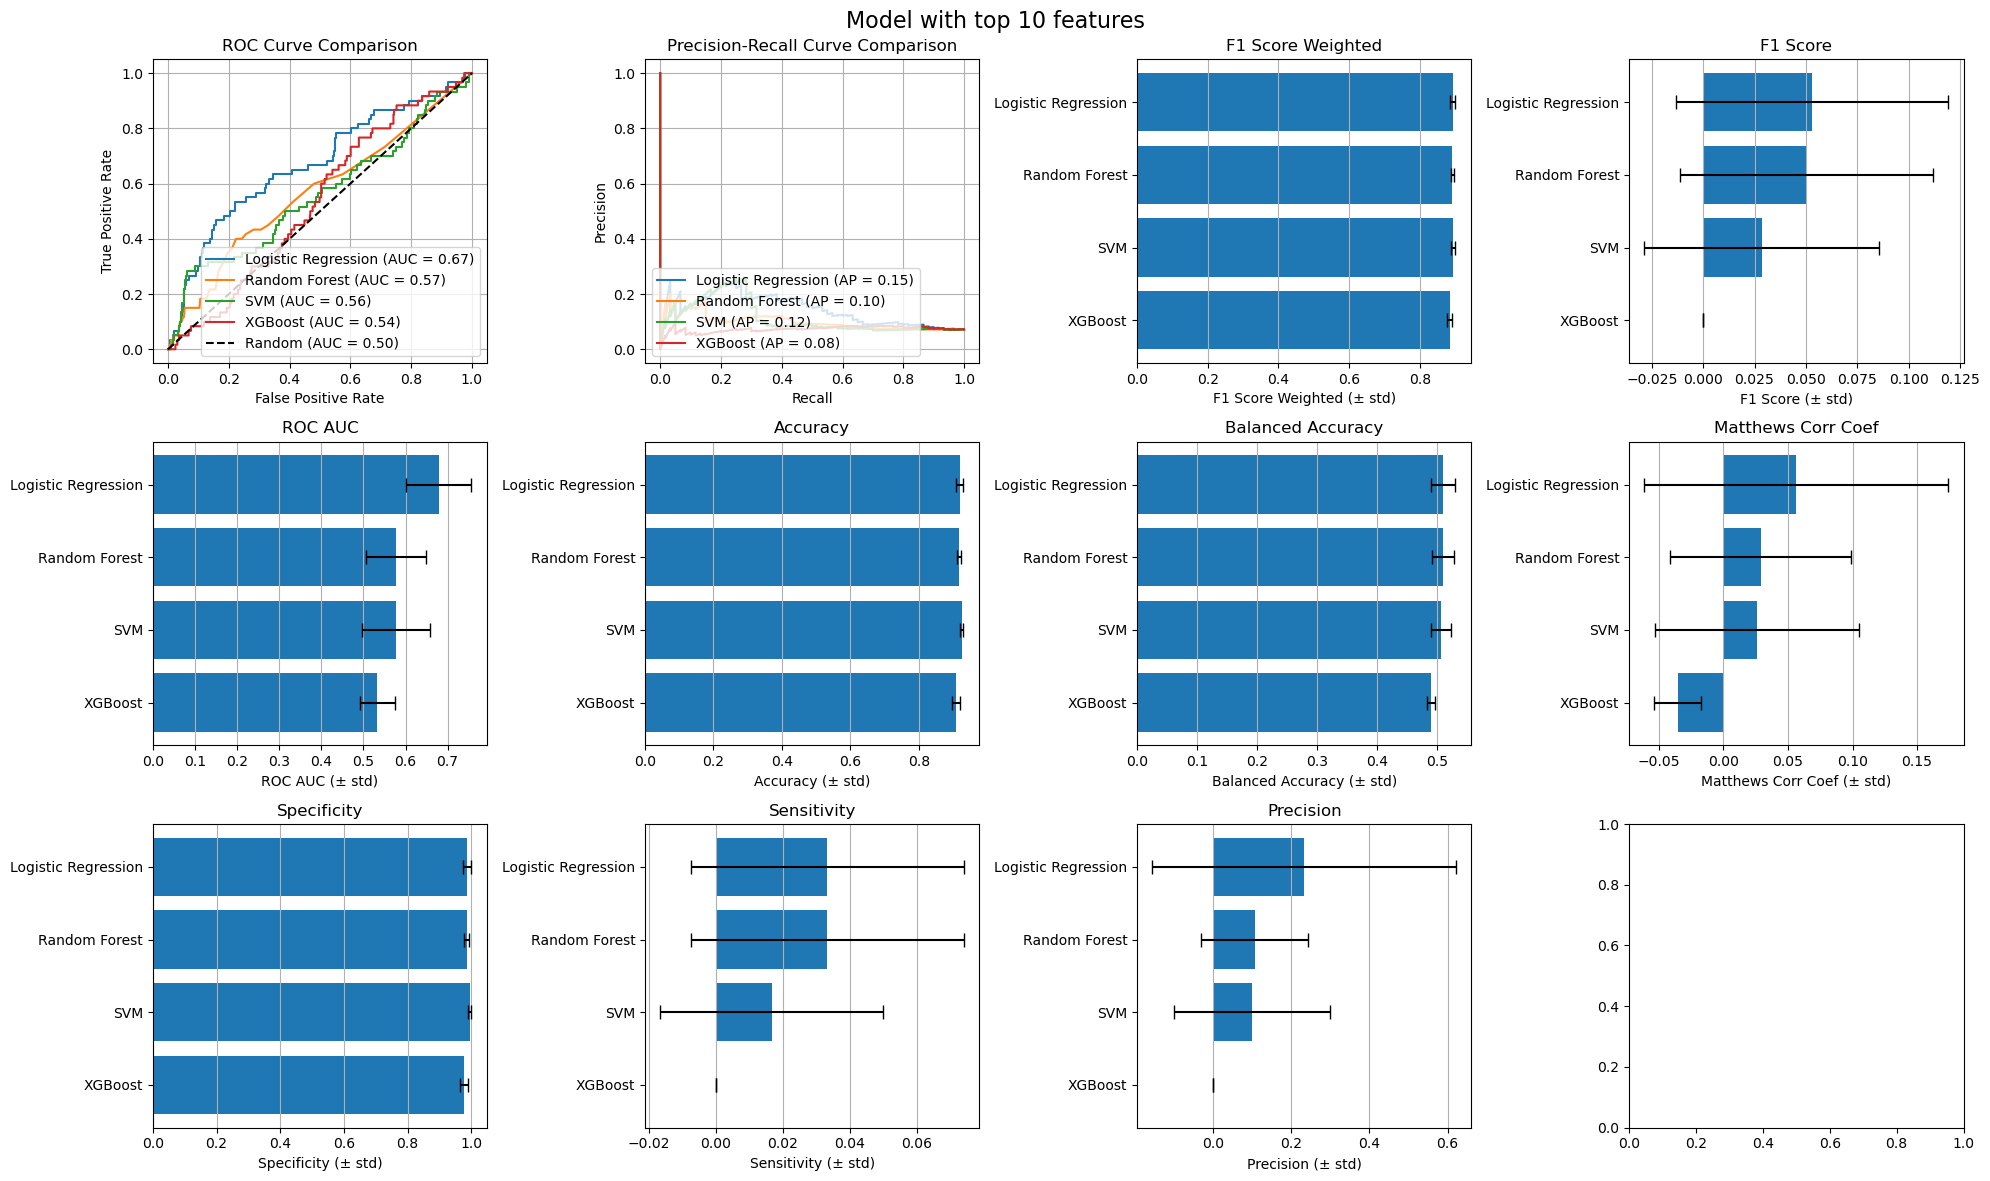

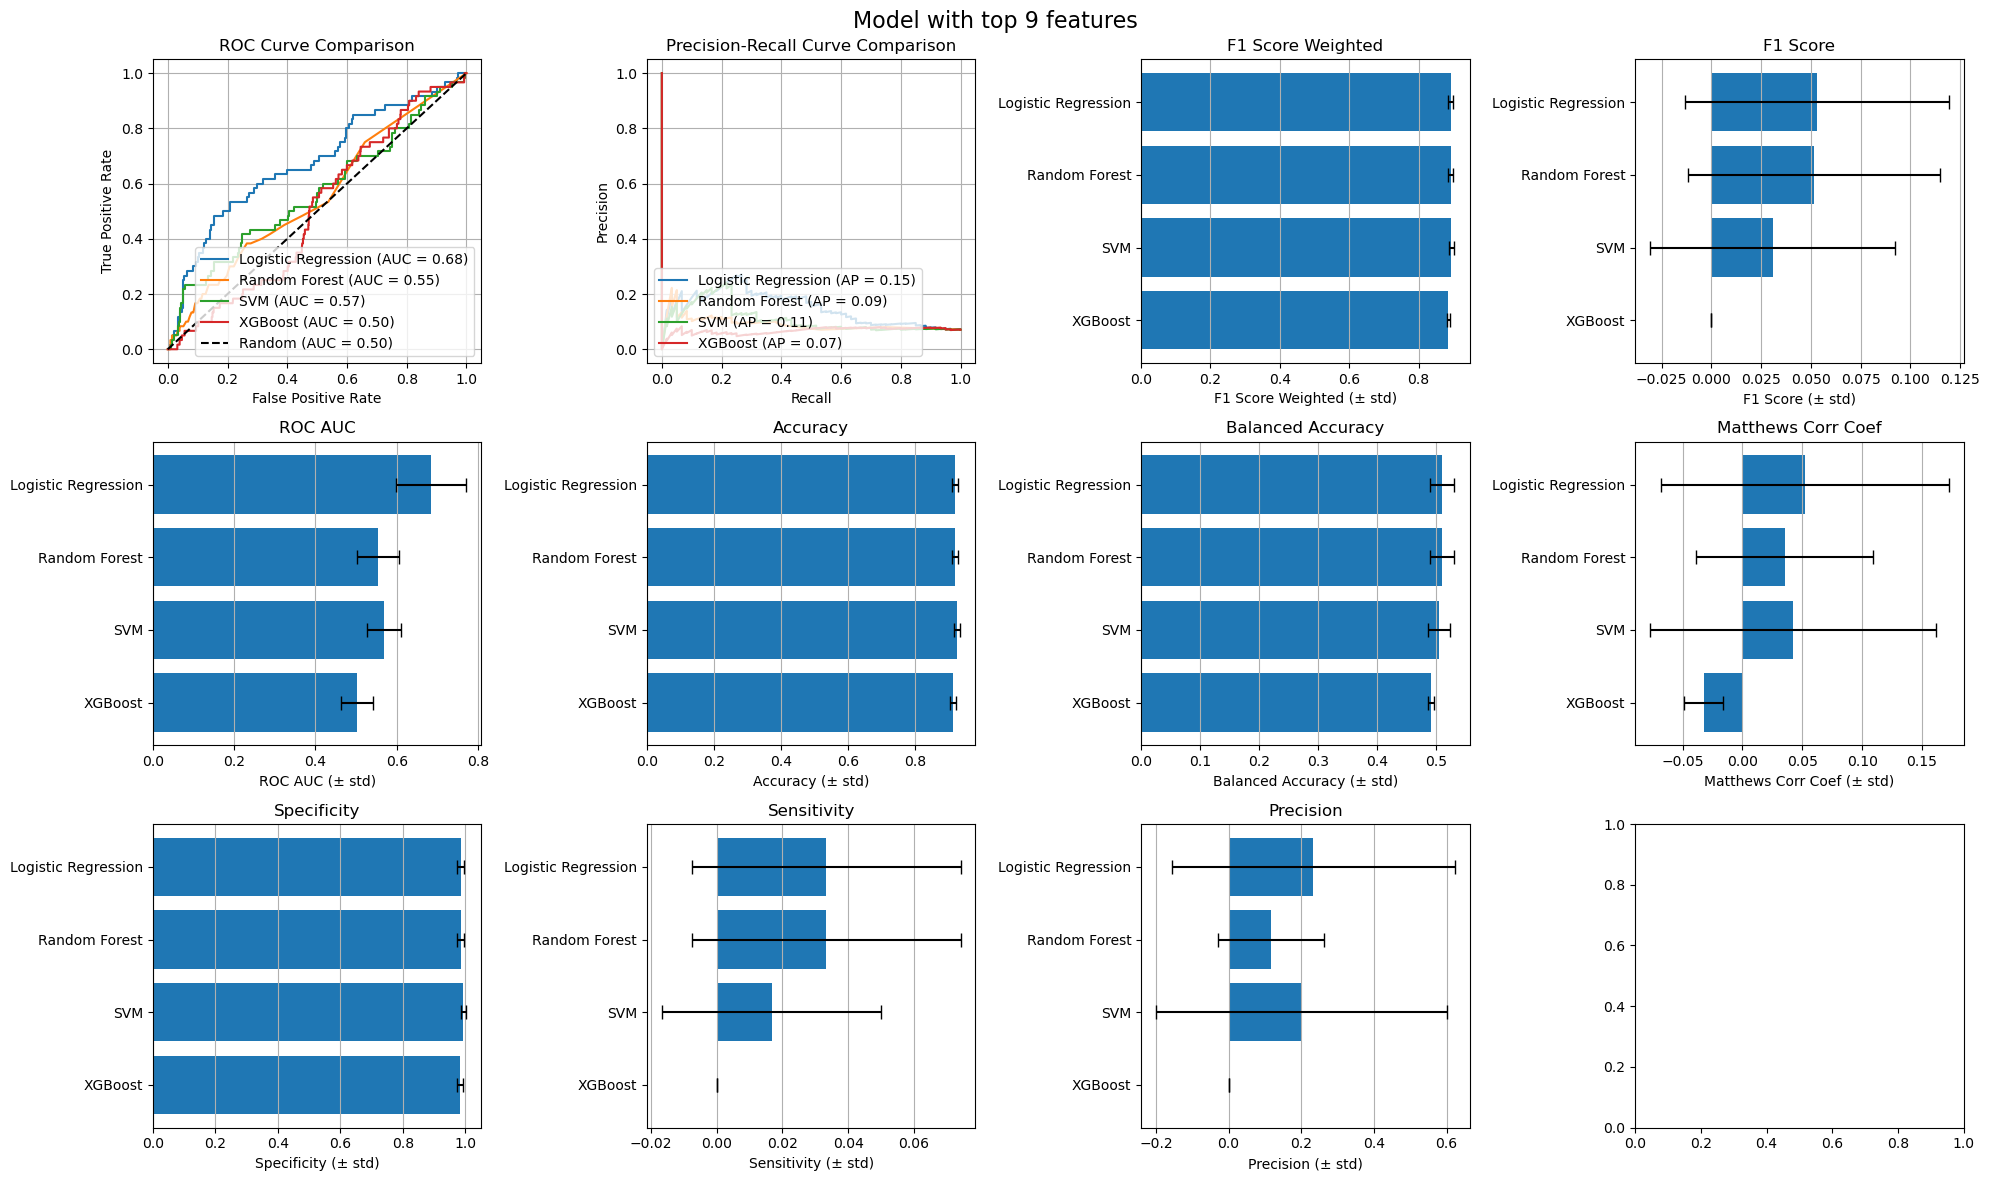

In [214]:
feature_counts, f1_means, f1_stds = [], [], []
for k, models in results.items():
    feature_counts.append(k)
    f1_means.append(np.mean([model['F1 Score']['mean'] for model in models.values()]))
    f1_stds.append(np.std([model['F1 Score']['std'] for model in models.values()]))
    
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(feature_counts, f1_means, yerr=f1_stds, fmt='o-', capsize=4, label="F1 Score ± std")

ax.set_xlabel("Number of Selected Features")
ax.set_ylabel("F1 Score")
ax.set_title("Model Performance vs. Feature Count")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

for k in top_k:
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))

    plot_roc_curves(results[k], ax=axes[0, 0])
    plot_precision_recall_curves(results[k], ax=axes[0, 1])
    plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
    plot_classification_metric(results[k], ax=axes[0, 3], metric='F1 Score')
    plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
    plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 2], metric='Balanced Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 3], metric='Matthews Corr Coef')
    plot_classification_metric(results[k], ax=axes[2, 0], metric='Specificity')
    plot_classification_metric(results[k], ax=axes[2, 1], metric='Sensitivity')
    plot_classification_metric(results[k], ax=axes[2, 2], metric='Precision')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()

<h1>Save results</h1>

In [152]:
timestamp = datetime.datetime.now().strftime("%m%d_%H-%M")
print(f"Timestamp: {timestamp}")

output=f'results/cv_results/multi_modal_dfs_{timestamp}.pkl'

os.makedirs("results/cv_results", exist_ok=True)
with open(output, "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {output}")

Timestamp: 0607_22-52
Results saved to results/cv_results/multi_modal_dfs_0607_22-52.pkl


<h1>hyper param tune</h1>

Evaluating models with top 11 features...
Evaluating models with top 10 features...
Evaluating models with top 9 features...
Evaluating models with top 19 features...
Using all 18 features.
Using all 18 features.
Using all 18 features.
Using all 18 features.
Using all 18 features.


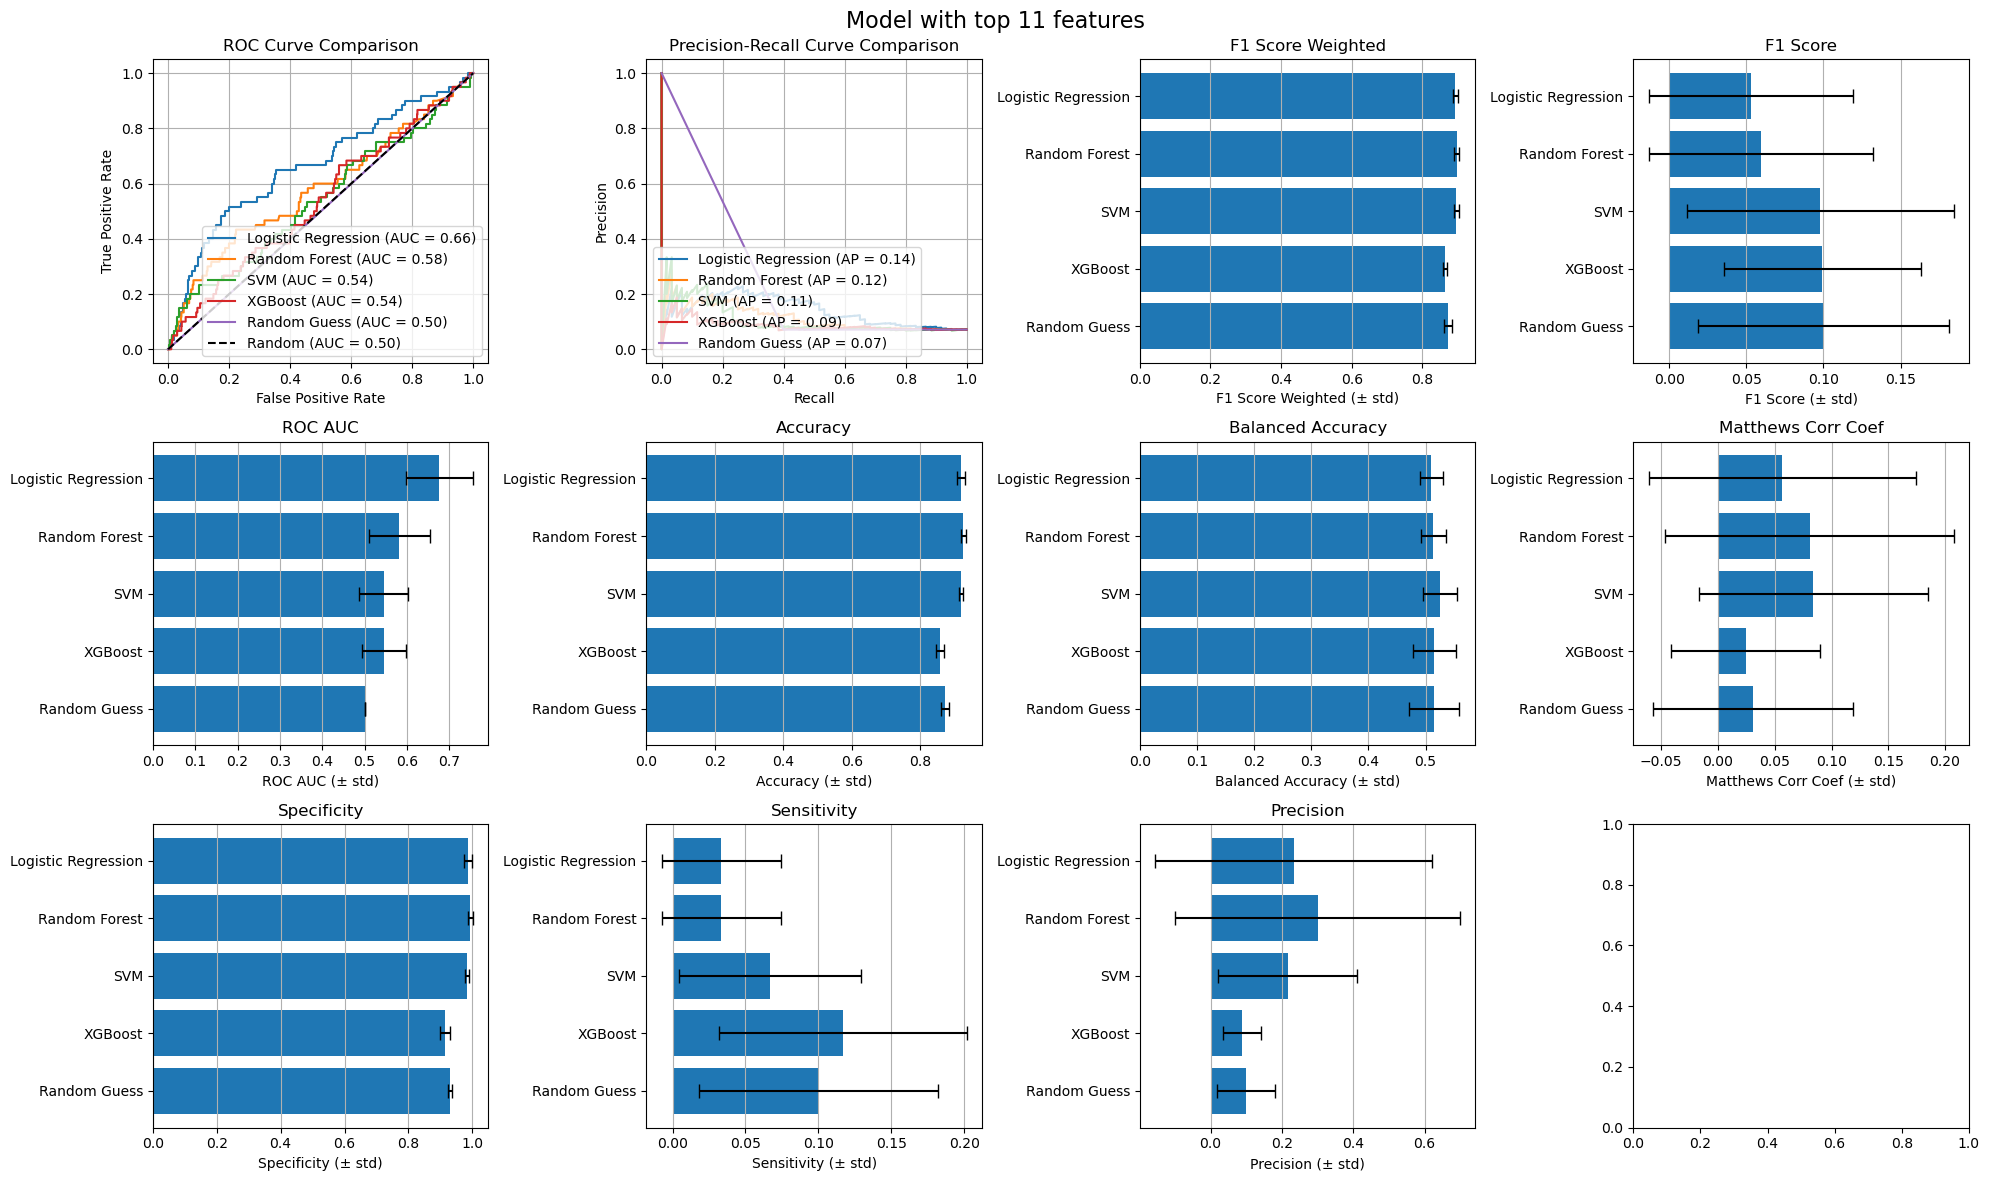

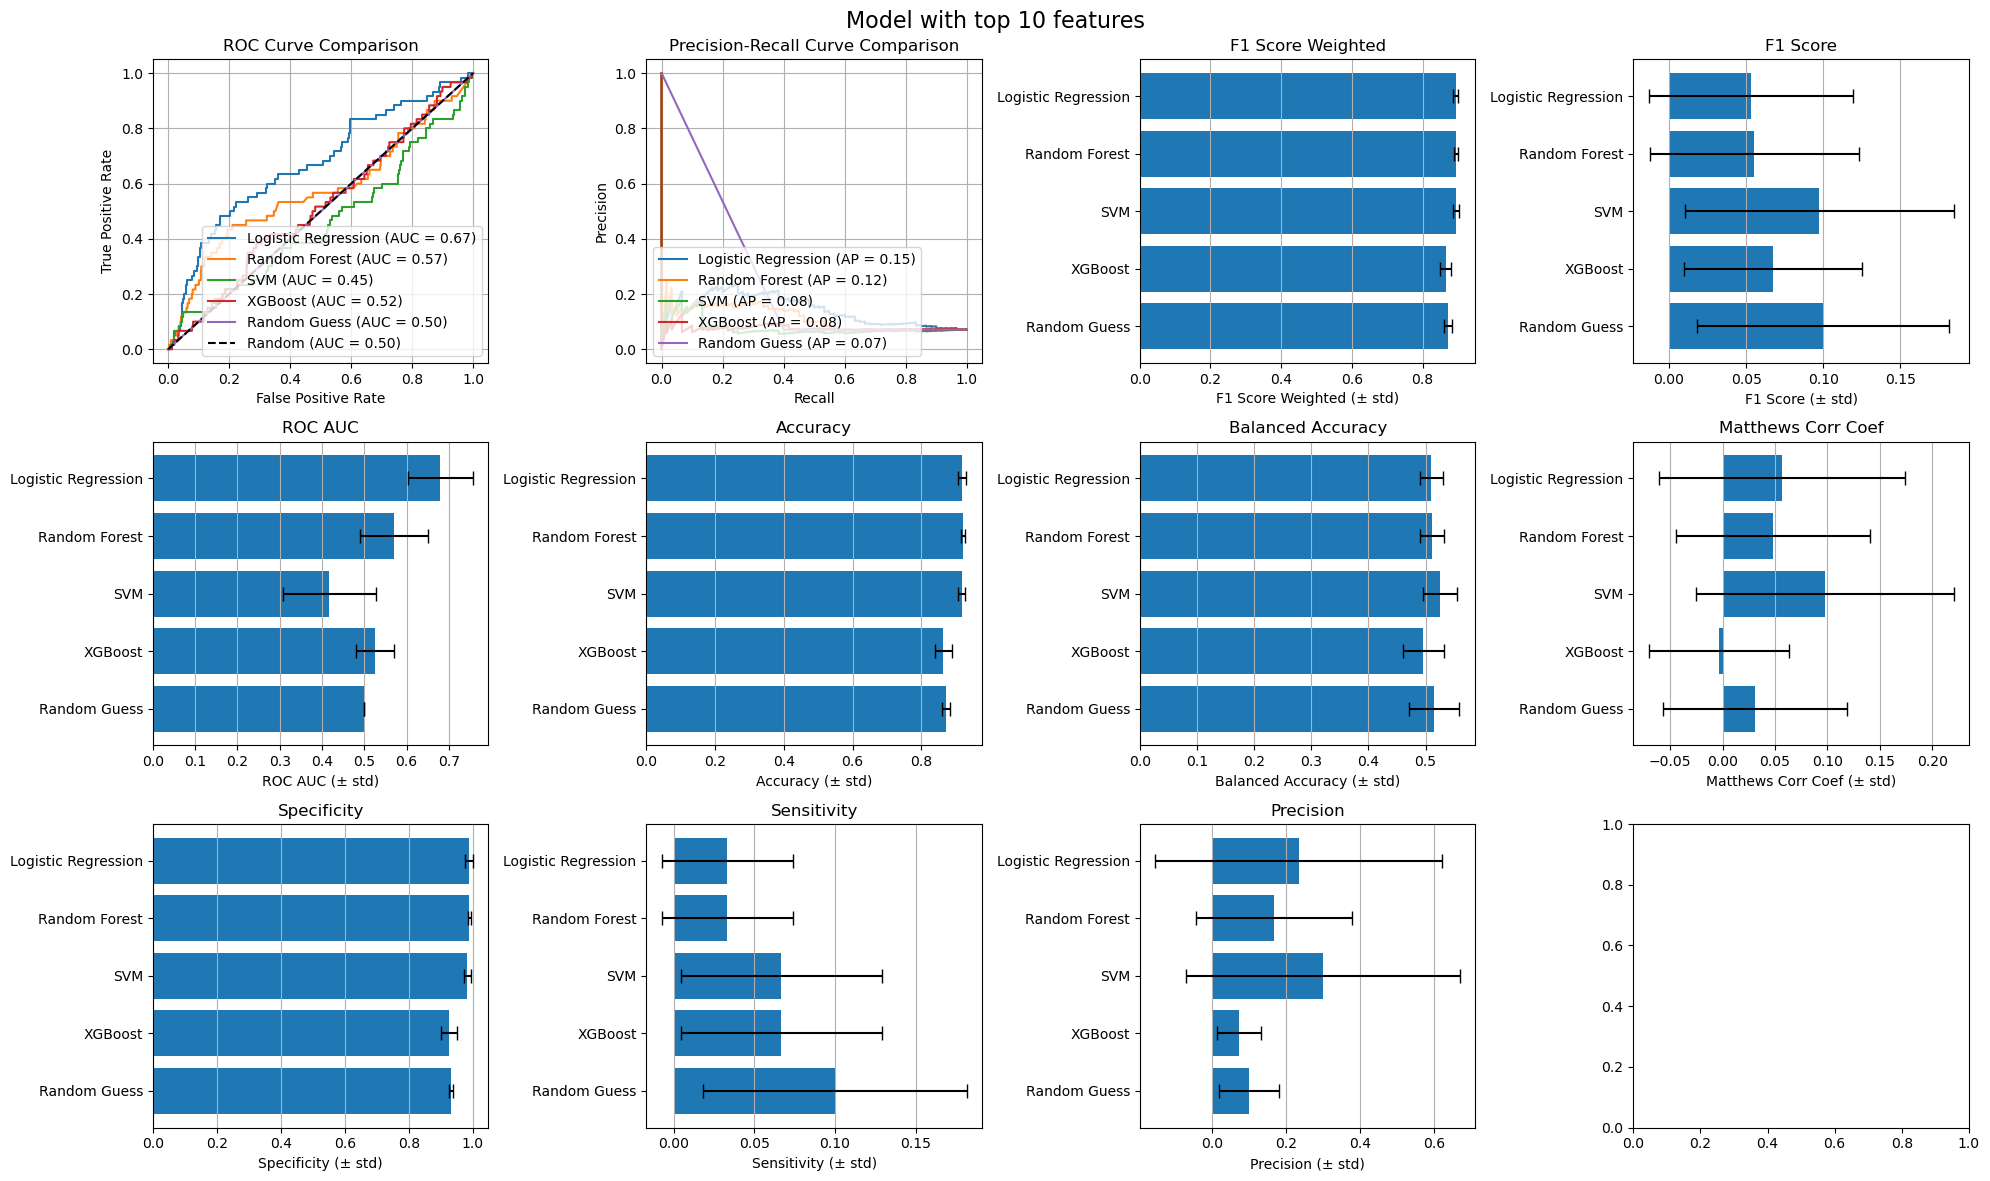

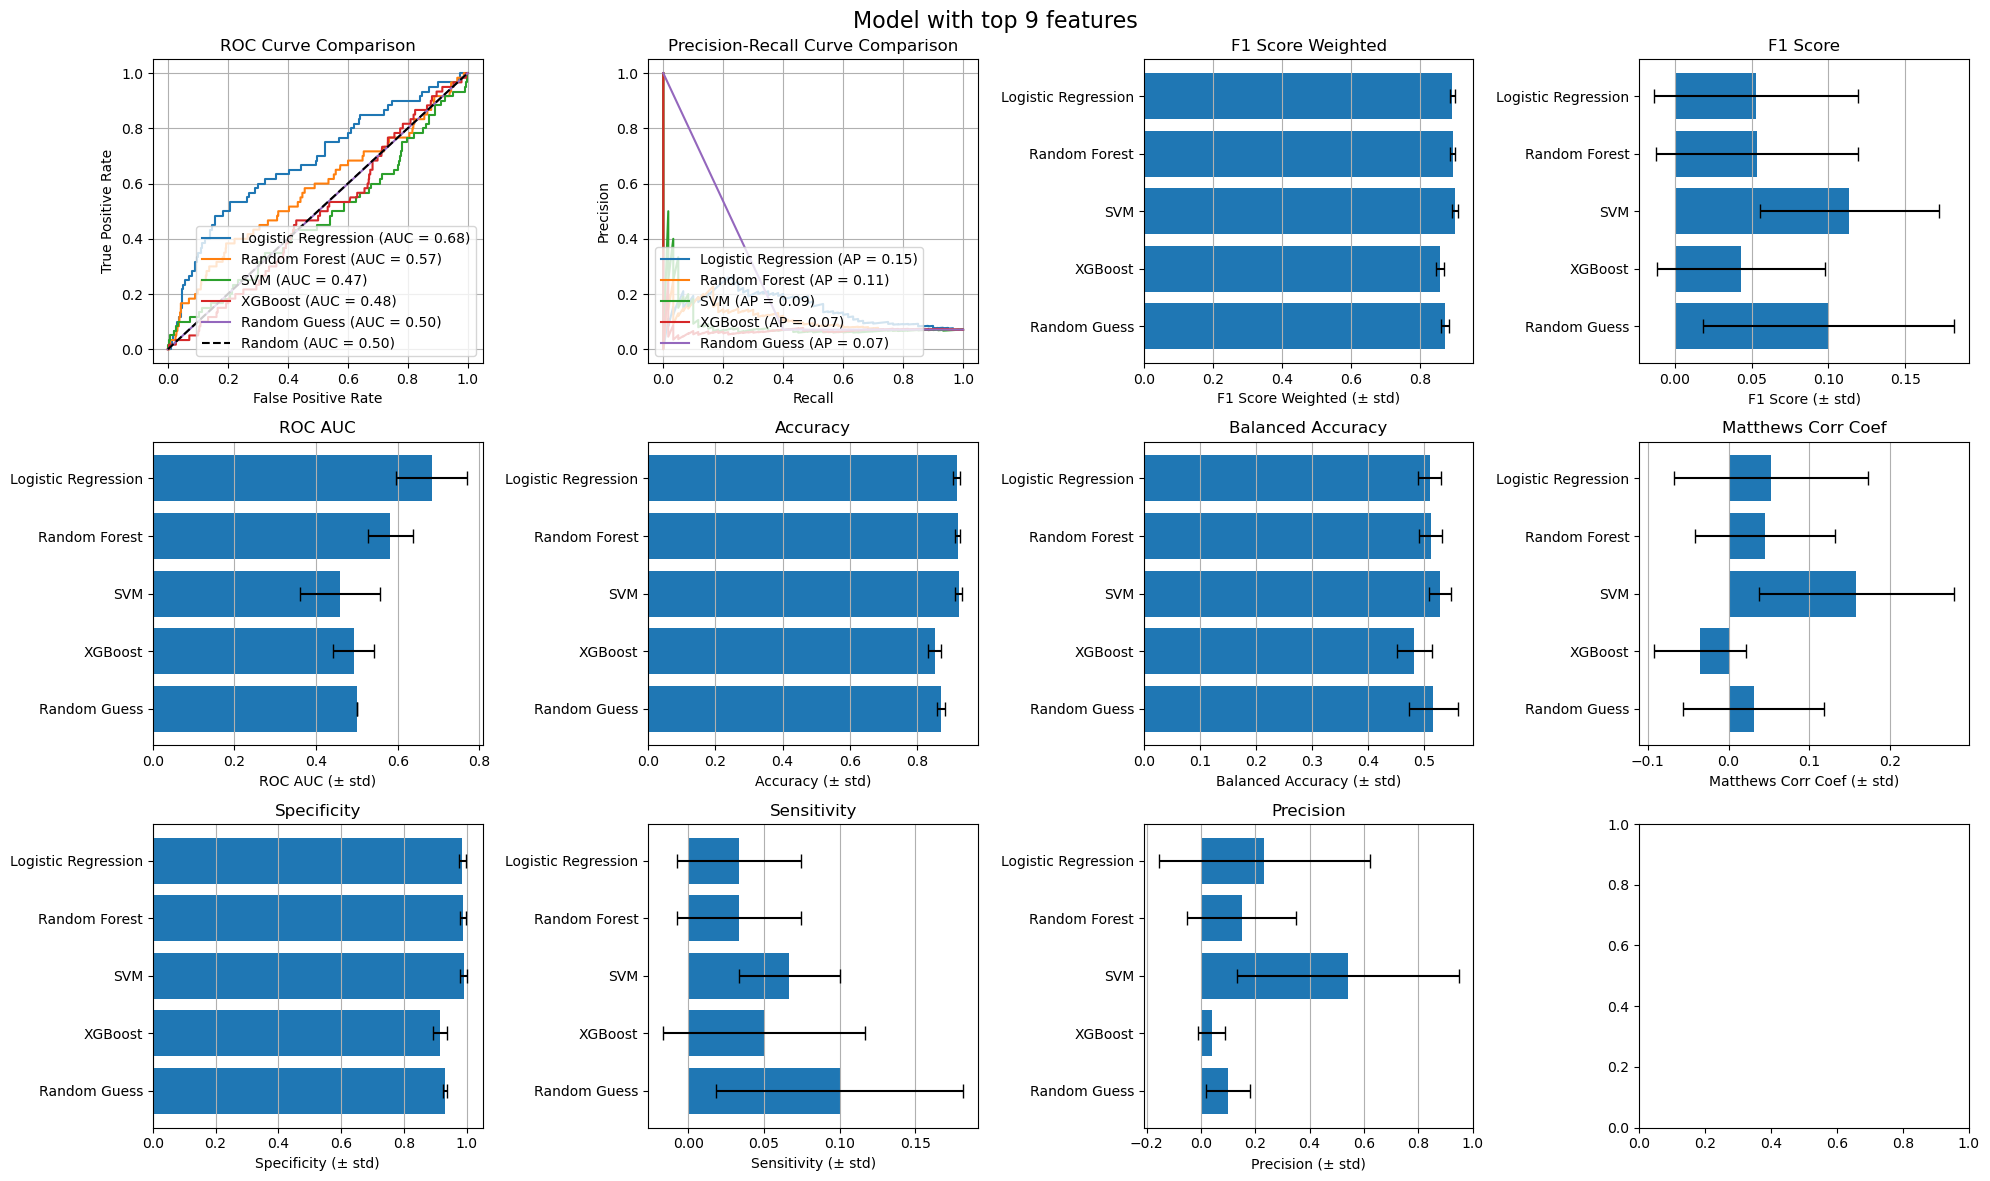

In [ ]:
top_k = [11,10,9, 19]
# evaluate models with different number of features
results = {}
for k in top_k:
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models_nested(X, y, filter_data=training_fold_filtering, k=k, preprocess=preprocessor)

# find the top 4 models based on average of models' f1 score
f1_scores = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['F1 Score']['global'])
    f1_scores.append(np.mean(scores))
    result_k.append(k)

for k in top_k:
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))

    plot_roc_curves(results[k], ax=axes[0, 0])
    plot_precision_recall_curves(results[k], ax=axes[0, 1])
    plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
    plot_classification_metric(results[k], ax=axes[0, 3], metric='F1 Score')
    plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
    plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 2], metric='Balanced Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 3], metric='Matthews Corr Coef')
    plot_classification_metric(results[k], ax=axes[2, 0], metric='Specificity')
    plot_classification_metric(results[k], ax=axes[2, 1], metric='Sensitivity')
    plot_classification_metric(results[k], ax=axes[2, 2], metric='Precision')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()

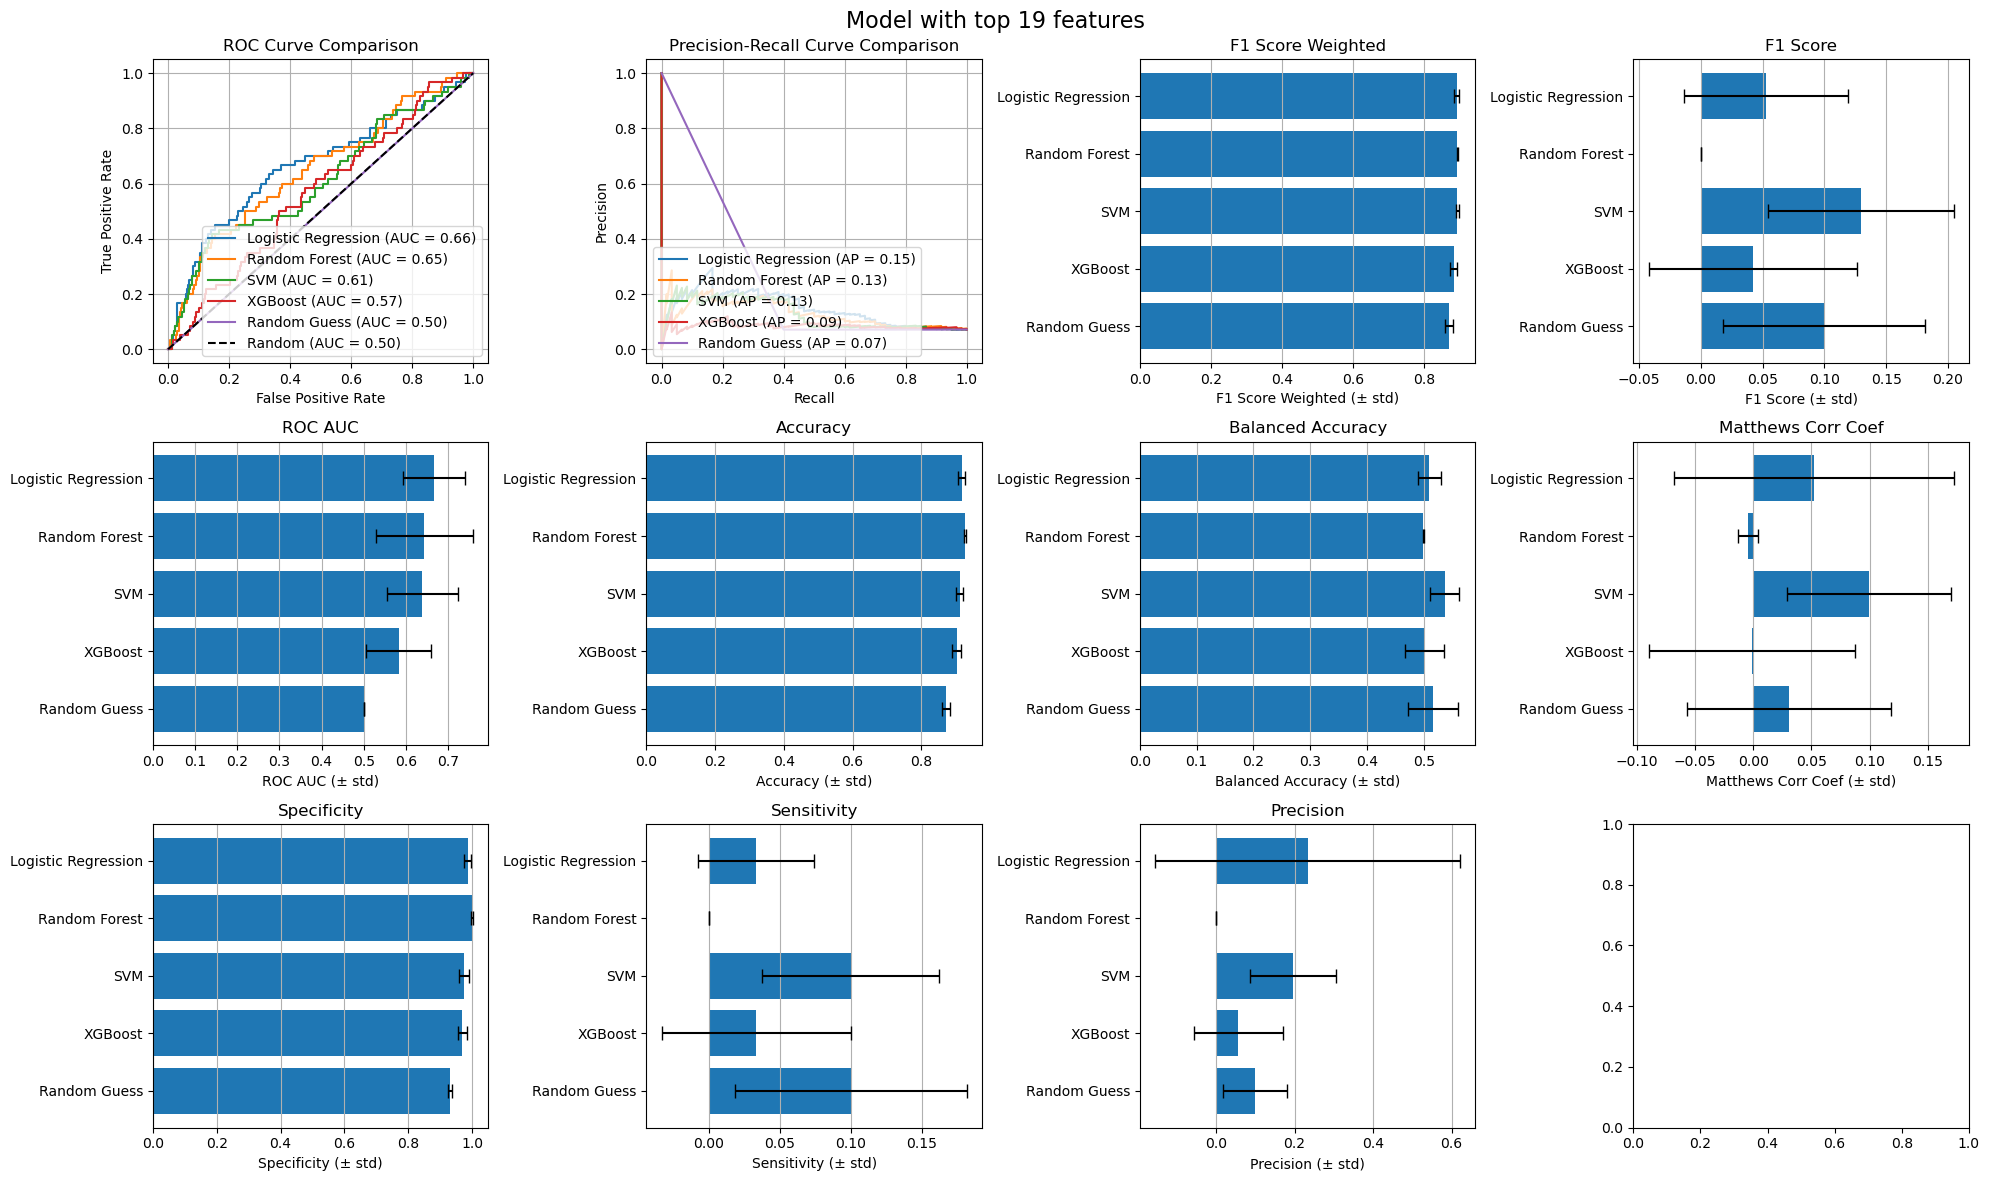

In [23]:
k=19
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

plot_roc_curves(results[k], ax=axes[0, 0])
plot_precision_recall_curves(results[k], ax=axes[0, 1])
plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
plot_classification_metric(results[k], ax=axes[0, 3], metric='F1 Score')
plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
plot_classification_metric(results[k], ax=axes[1, 2], metric='Balanced Accuracy')
plot_classification_metric(results[k], ax=axes[1, 3], metric='Matthews Corr Coef')
plot_classification_metric(results[k], ax=axes[2, 0], metric='Specificity')
plot_classification_metric(results[k], ax=axes[2, 1], metric='Sensitivity')
plot_classification_metric(results[k], ax=axes[2, 2], metric='Precision')
fig.suptitle(f"Model with top {k} features", fontsize=16)
fig.tight_layout()

In [18]:
timestamp = datetime.datetime.now().strftime("%m%d_%H-%M")
print(f"Timestamp: {timestamp}")

output=f'results/cv_results/mut_sig_nested_{timestamp}.pkl'

os.makedirs("results/cv_results", exist_ok=True)
with open(output, "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {output}")

Timestamp: 0607_15-57
Results saved to results/cv_results/mut_sig_nested_0607_15-57.pkl
